The U-Net architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization. Localization means that a class label is supposed to be assigned to each pixel. In the architecture, in the upsampling part we have also a large number of feature channels, which allow the network to propagate context information to higher resolution layers. As a consequence, the expansive path is more or less symmetric to the contracting path, and yields a u-shaped architecture. As we are using features from different layers, good localization and the use of context is possible at the same time.
<br>
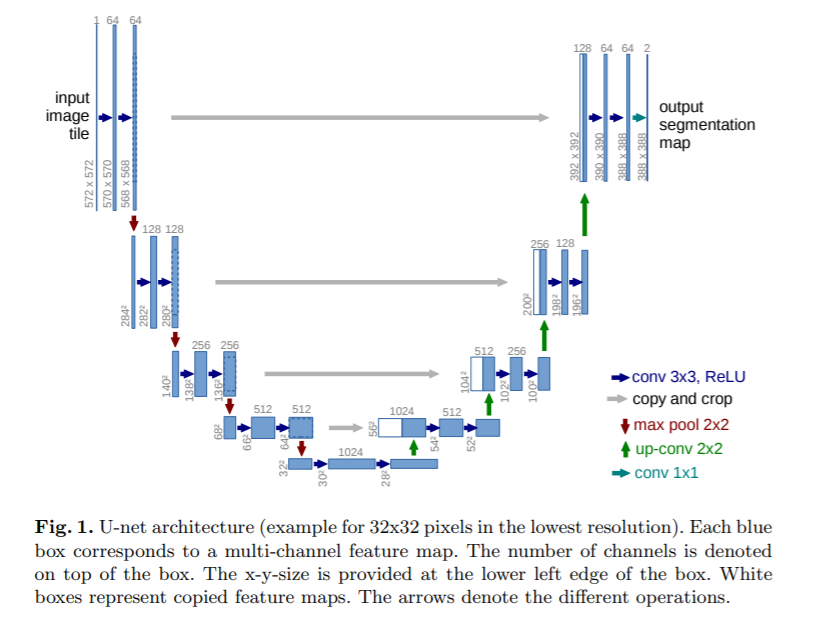
<br> The U-Net architecture is great for segmentation tasks and leads to improvements in Warping Error, Rand Error and Pixel Error.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class DoubleConv(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.double_conv(x)

class UpConcatConv(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1)  # 1x1 convolution to reduce num of channels to half
        )
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        # No need to crop the feature maps from the corresponding contracting layer since we using padding in DoubleConv
        x = torch.cat((x2, x1), dim=1)
        return self.conv(x)

In [3]:
class UNet(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.dconv1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.dconv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.dconv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.dconv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.dconv5 = DoubleConv(512, 1024)
        self.up1 = UpConcatConv(1024, 512)
        self.up2 = UpConcatConv(512, 256)
        self.up3 = UpConcatConv(256, 128)
        self.up4 = UpConcatConv(128, 64)
        self.outconv = nn.Conv2d(64, out_channels, kernel_size=1)  # Final 1x1 convolution
    
    def forward(self, x):
        x1 = self.dconv1(x)
        x2 = self.pool1(x1)
        x2 = self.dconv2(x2)
        x3 = self.pool2(x2)
        x3 = self.dconv3(x3)
        x4 = self.pool3(x3)
        x4 = self.dconv4(x4)
        x5 = self.pool4(x4)
        x5 = self.dconv5(x5)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outconv(x)

In [4]:
data = torch.randn(1,3,256,256)

In [5]:
data.size()

torch.Size([1, 3, 256, 256])

In [16]:
model = UNet(3,2)

In [17]:
out = model(data)

In [18]:
out.shape

torch.Size([1, 2, 256, 256])

In [ ]:
out

In [30]:
for type_str, model in [('model', model)]:
    print(type_str)
    for name_str, param in model.named_parameters():
        print("{:21} {:19} {}".format(name_str, str(param.shape), param.numel()))
        print()

model
dconv1.double_conv.0.weight torch.Size([64, 3, 3, 3]) 1728

dconv1.double_conv.0.bias torch.Size([64])    64

dconv1.double_conv.1.weight torch.Size([64])    64

dconv1.double_conv.1.bias torch.Size([64])    64

dconv1.double_conv.3.weight torch.Size([64, 64, 3, 3]) 36864

dconv1.double_conv.3.bias torch.Size([64])    64

dconv1.double_conv.4.weight torch.Size([64])    64

dconv1.double_conv.4.bias torch.Size([64])    64

dconv2.double_conv.0.weight torch.Size([128, 64, 3, 3]) 73728

dconv2.double_conv.0.bias torch.Size([128])   128

dconv2.double_conv.1.weight torch.Size([128])   128

dconv2.double_conv.1.bias torch.Size([128])   128

dconv2.double_conv.3.weight torch.Size([128, 128, 3, 3]) 147456

dconv2.double_conv.3.bias torch.Size([128])   128

dconv2.double_conv.4.weight torch.Size([128])   128

dconv2.double_conv.4.bias torch.Size([128])   128

dconv3.double_conv.0.weight torch.Size([256, 128, 3, 3]) 294912

dconv3.double_conv.0.bias torch.Size([256])   256

dconv3.double_